In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from scipy.stats import circvar, circmean, circstd

# general libraries
import os  
import json
import time
import h5py as h5py
import copy
from functools import partial

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace, pack_hdf
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
multiplex_base_paths = {
    "vc": os.path.join(base_path, "multiplex_vc_figs"),
    "spk": os.path.join(base_path, "multiplex_rho_figs"),
}
fig_path = os.path.join(base_path, "multiplex_spk_vc_figs")
fig_subdir = None

fig_subdir, analysis_names = ("rho95_vs_rho95flat", {
    "vc": "rho95_vs_rho95flat_rhoreset",
    "spk": "fixed_rho95_vs_rho95flat",
})
# fig_subdir, analysis_names = ("ctrl_vs_plex", {
#     "vc": "ctrl_vs_plex",
#     "spk": "ctrl_vs_plex",
# })

fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
analysis_hdfs = {
    k: h5.File(os.path.join(multiplex_base_paths[k], n, "analysis.h5"), "r")
    for k, n in analysis_names.items()
}
d = {k: Workspace(hdf, read_only=True) for k, hdf in analysis_hdfs.items()}
os.makedirs(fig_path, exist_ok=True)

# use experiments included in vc since they'll should be a subset of spk (if they differ)
exps = list(d["vc"]["rho_vs_corr_avg"].keys())

for k, wrk in d.items():
    print("==%s datasets==" % k)
    for name in wrk.keys():
        print(name)
    print("")
    
print("exps:", exps)

==vc datasets==
dir_labels
full_xaxis
residual_corr_full_net_avg
residual_corr_full_net_std
residual_corr_full_peak_net_avg
residual_corr_full_peak_net_std
residuals_ei_sum_neg_area
residuals_ei_sum_pos_area
residuals_neg_area
residuals_pos_area
rho_vs_corr_avg
rho_vs_corr_std
rhos
vc_net_avgs
vc_trial_avgs
xaxis

==spk datasets==
avg_dir_spikes
circ_180
dir_labels
dir_sort
dirs_180
dirs_180_sorted
dirs_sorted
metrics
net_mets
rho_avg_dsis
rho_avg_spks
rho_dsis
rho_net_avg_dsis
rho_net_avg_spks
rho_spks
rhos
std_dir_spikes
xaxis

exps: ['ctrl', 'flat']


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
# list(d["vc"]["residual_corr_full_peak_net_avg"]["ctrl"].keys())
# d["vc"]["rho_vs_corr_avg"]["ctrl"].shape
# d["spk"]["rho_net_avg_dsis"]["ctrl"].shape

dir_labels = d["vc"]["dir_labels"][:]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
pos_ortho_idx = np.argwhere(dir_labels == 90)[0][0]
neg_ortho_idx = np.argwhere(dir_labels == 270)[0][0]

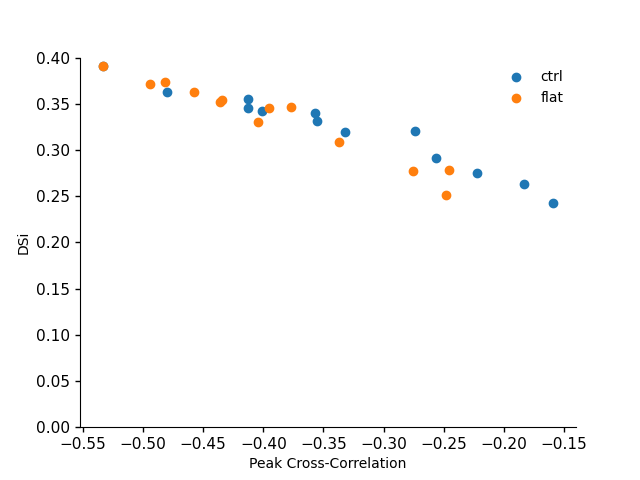

In [7]:
peak_null_corr_vs_dsi_fig, peak_null_corr_vs_dsi_ax = plt.subplots(1)
for exp in exps:
    peak_null_corr_vs_dsi_ax.scatter(
        d["vc"]["rho_vs_corr_avg"][exp][null_idx],
        np.mean(d["spk"]["rho_net_avg_dsis"][exp], axis=-1),
        label=exp,
    )

peak_null_corr_vs_dsi_ax.set_ylim(0, 0.4)
peak_null_corr_vs_dsi_ax.set_ylabel("DSi")
peak_null_corr_vs_dsi_ax.set_xlabel("Peak Cross-Correlation")
peak_null_corr_vs_dsi_ax.legend(frameon=False)
clean_axes(peak_null_corr_vs_dsi_ax)

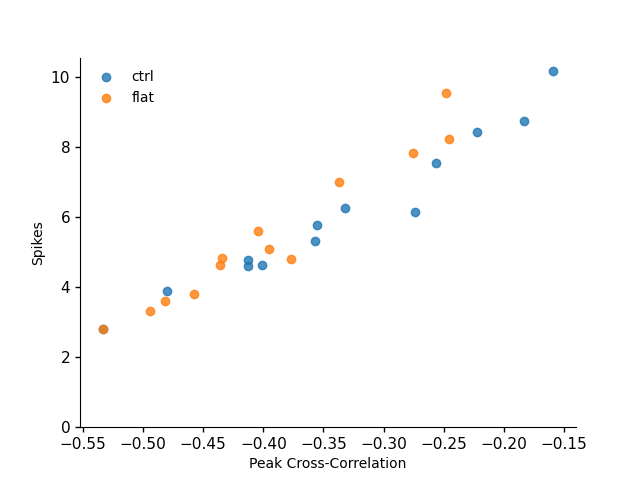

In [8]:
dir_idx = null_idx 
peak_corr_vs_spks_fig, peak_corr_vs_spks_ax = plt.subplots(1)
for exp in exps:
    peak_corr_vs_spks_ax.scatter(
        d["vc"]["rho_vs_corr_avg"][exp][dir_idx],
        np.mean(d["spk"]["rho_net_avg_spks"][exp][:, dir_idx], axis=-1),
        alpha=0.8,
        label=exp,
    )
    
peak_corr_vs_spks_ax.set_ylim(0)
peak_corr_vs_spks_ax.set_ylabel("Spikes")
peak_corr_vs_spks_ax.set_xlabel("Peak Cross-Correlation")
peak_corr_vs_spks_ax.legend(frameon=False)
clean_axes(peak_corr_vs_spks_ax)

In [9]:
close_button()